## Sample from a feature distribution (mimicking GC content, say)

Text(0, 0.5, 'number of examples')

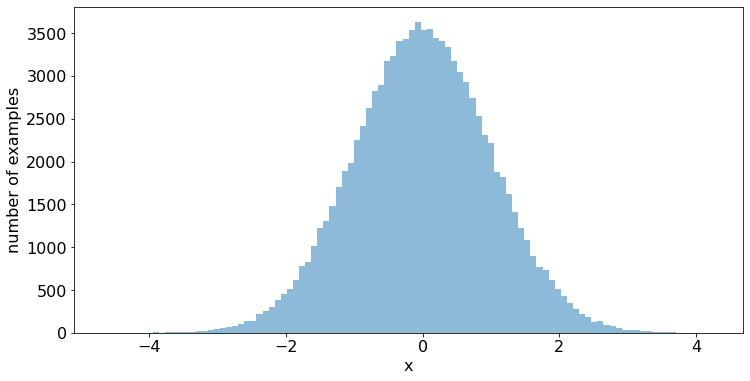

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

NUMBER_EXAMPLES = 100000 # Number of intervals

# Sample from a univariate normal distribution
MEAN = 0
STD = 1
xs = np.random.normal(loc=MEAN, scale=STD, size=NUMBER_EXAMPLES)

plt.figure(figsize=(12, 6))
plt.hist(xs, bins=100, alpha=0.5)
plt.xlabel('x')
plt.ylabel('number of examples')

## True mapping from feature to target (mimicking SNV counts)

Text(0, 0.5, 'number of examples')

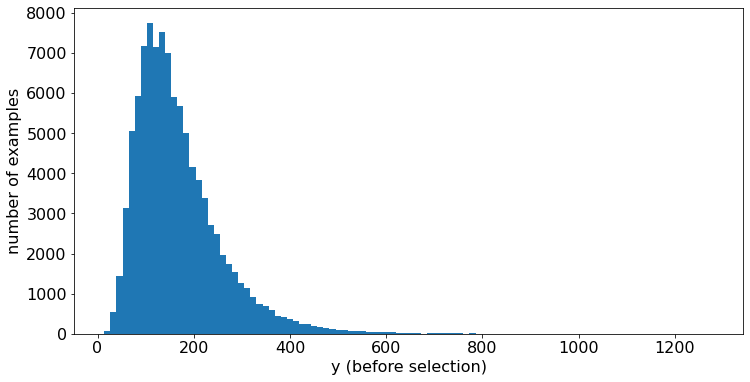

In [2]:
# parameters of true model 
A = 5 
B = 0.5 

ys = np.random.poisson(lam=np.exp(A + B*xs)) # target 

plt.figure(figsize=(12, 6))
plt.hist(ys, bins=100)
plt.xlabel('y (before selection)')
plt.ylabel('number of examples')

## Introduce selection into a small fraction of examples

In [3]:
# Take x% of the examples, declare them to be positive examples, and reduce their y values (possibly in proportion to x), 
# to mimic the effect of negative selection (and how it occurs more often in regions with higher GC content)

# Take the remaining examples, declare them to be neutral (negative) examples, and do not change their y values

POSITIVE_FRACTION = 0.2

num_pos = int(POSITIVE_FRACTION*NUMBER_EXAMPLES)

# FRACTIONAL_REDUCTION_IN_Y = 0.1
# x_factor = (xs - xs.min()) / (xs.max() - xs.min())
# y_pos = ys[:num_pos] * (1 - FRACTIONAL_REDUCTION_IN_Y * x_factor[:num_pos])

Y_DEPLETION = 20
y_pos = np.maximum(0, ys[:num_pos] - Y_DEPLETION)
y_neg = ys[num_pos:]
ys = np.concatenate([y_pos, y_neg])

constrained = num_pos*[True] + (NUMBER_EXAMPLES-num_pos)*[False]

DATA = pd.DataFrame({'x': xs, 'y': ys, 'constrained': constrained})
DATA

,x,y,constrained
0,0.701584,192,True
1,-0.600254,73,True
2,-0.478495,87,True
3,-1.852048,43,True
4,-1.200792,47,True
...,...,...,...
99995,1.581640,331,False
99996,-1.289054,73,False
99997,0.162810,153,False
99998,-0.022434,141,False


<AxesSubplot:xlabel='x', ylabel='y'>

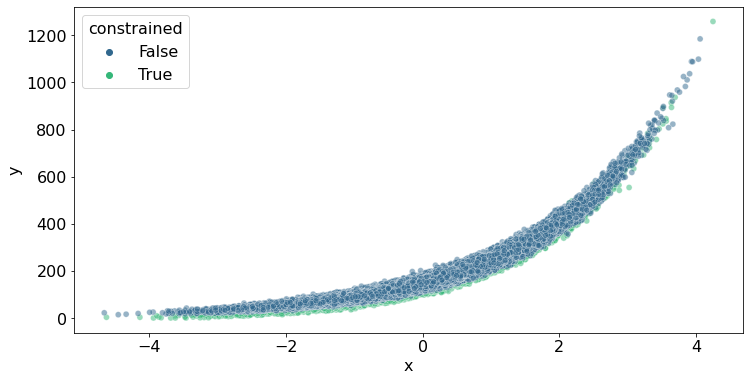

In [4]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x', y='y', hue='constrained', palette='viridis', alpha=0.5)

## Recover the model that generated the neutral data

In [5]:
import statsmodels.api as sm

def fit_poisson_model(feature='x'):
    data_neg = DATA[DATA['constrained'] == 0]
    x_model_neg = sm.add_constant(data_neg[feature])
    model = sm.Poisson(data_neg['y'], x_model_neg).fit()
    x_model = sm.add_constant(DATA[feature])
    DATA[f'predicted_y_model'] = model.predict(x_model)
    DATA[f'standardized_residuals_model'] = (
        DATA[f'predicted_y_model'] - DATA['y'] 
    ) / np.sqrt(DATA[f'predicted_y_model'])
    return model.params

# Fit Poisson Model 1: y ~ x
coefficients_model = fit_poisson_model()
print("Coefficients for Model:", coefficients_model)

DATA

Optimization terminated successfully.
         Current function value: 3.919521
         Iterations 5
Coefficients for Model: const    5.000191
x        0.499967
dtype: float64


,x,y,constrained,predicted_y_model,standardized_residuals_model
0,0.701584,192,True,210.810536,1.295553
1,-0.600254,73,True,109.956466,3.524358
2,-0.478495,87,True,116.858049,2.762054
3,-1.852048,43,True,58.805128,2.061059
4,-1.200792,47,True,81.437477,3.816095
...,...,...,...,...,...
99995,1.581640,331,False,327.326606,-0.203038
99996,-1.289054,73,False,77.921932,0.557578
99997,0.162810,153,False,161.030073,0.632799
99998,-0.022434,141,False,146.785932,0.477563


In [6]:
def plot_y(constrained):
    df = DATA[DATA['constrained'] == constrained]

    plt.figure(figsize=(12, 6))

    plt.plot(df['x'], df['y'], 'o', alpha=0.5, label='True y')
    plt.plot(df['x'], df['predicted_y_model'], 'o', label='Predicted y')
    plt.xlabel('x')
    plt.title(f'Constrained = {constrained}')
    plt.legend()

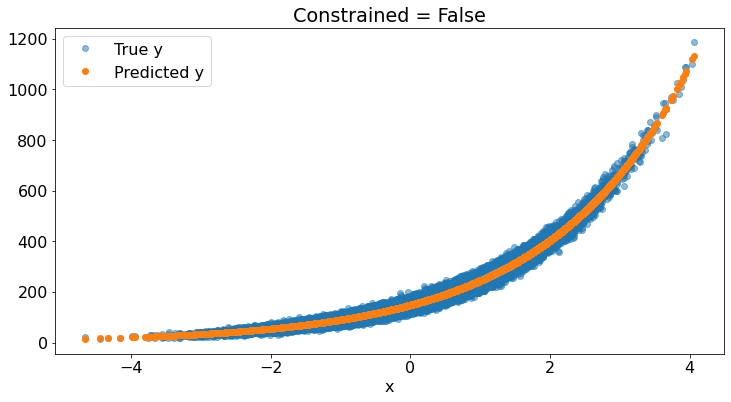

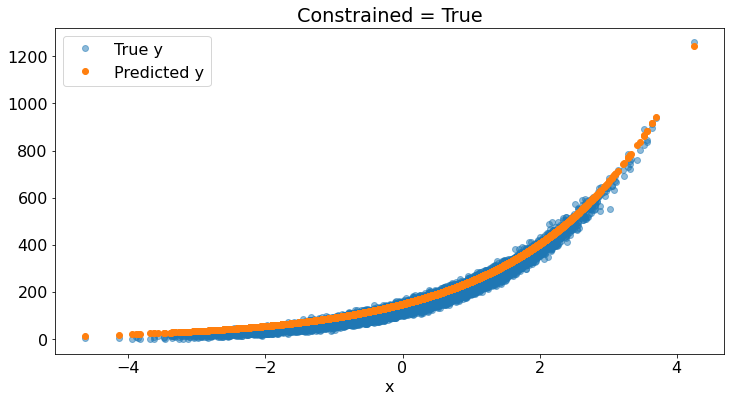

In [7]:
plot_y(constrained=False)
plot_y(constrained=True)

## Residual patterns for negative and positive examples

In [8]:
def plot_residuals(constrained):
    df = DATA[DATA['constrained'] == constrained].copy()

    df[f'x_bin_midpoints'] = (pd
        .cut(df['x'], bins=20, labels=None)
        .apply(lambda x: (x.right + x.left) / 2)
    )
    average_residual = df.groupby(f'x_bin_midpoints')[f'standardized_residuals_model'].mean()  

    plt.figure(figsize=(10, 6))
    plt.scatter(df['x'], df[f'standardized_residuals_model'], alpha=0.7, label='standardized residuals')
    plt.plot(average_residual.index, average_residual.values, color='red', lw=2, label=f'mean residual') 
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('x')
    plt.ylim(-10, 10)

    if constrained:
        x_ = np.linspace(df['x'].min(), df['x'].max(), 100)
        mu = np.exp(A + B*x_)
        sigma = np.sqrt(mu)
        y_ = Y_DEPLETION / sigma # this depends on how selection affects y values
        plt.plot(x_, y_, color='black', lw=2, label='expected mean')
    plt.legend()

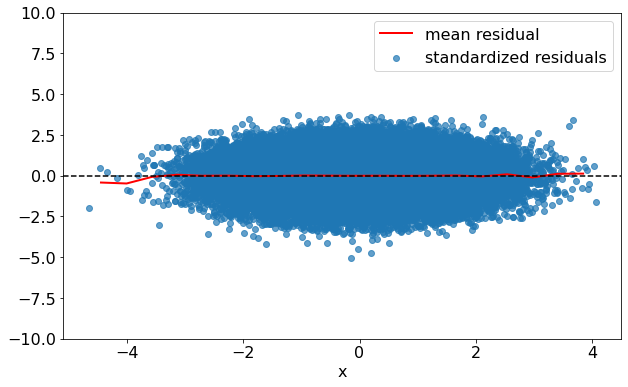

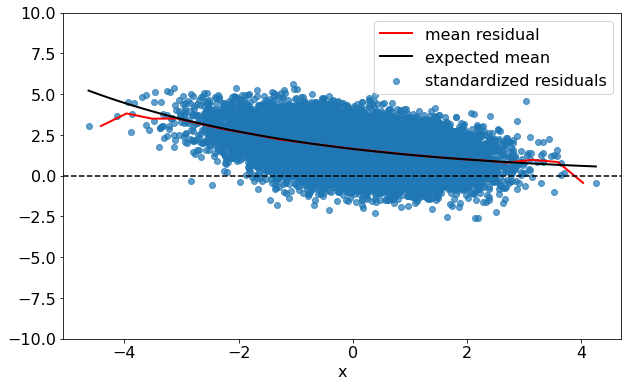

In [9]:
plot_residuals(constrained=False)
plot_residuals(constrained=True)

## Bias in the residuals of the positive examples causes performance to vary with feature stratum, even though the model is complete

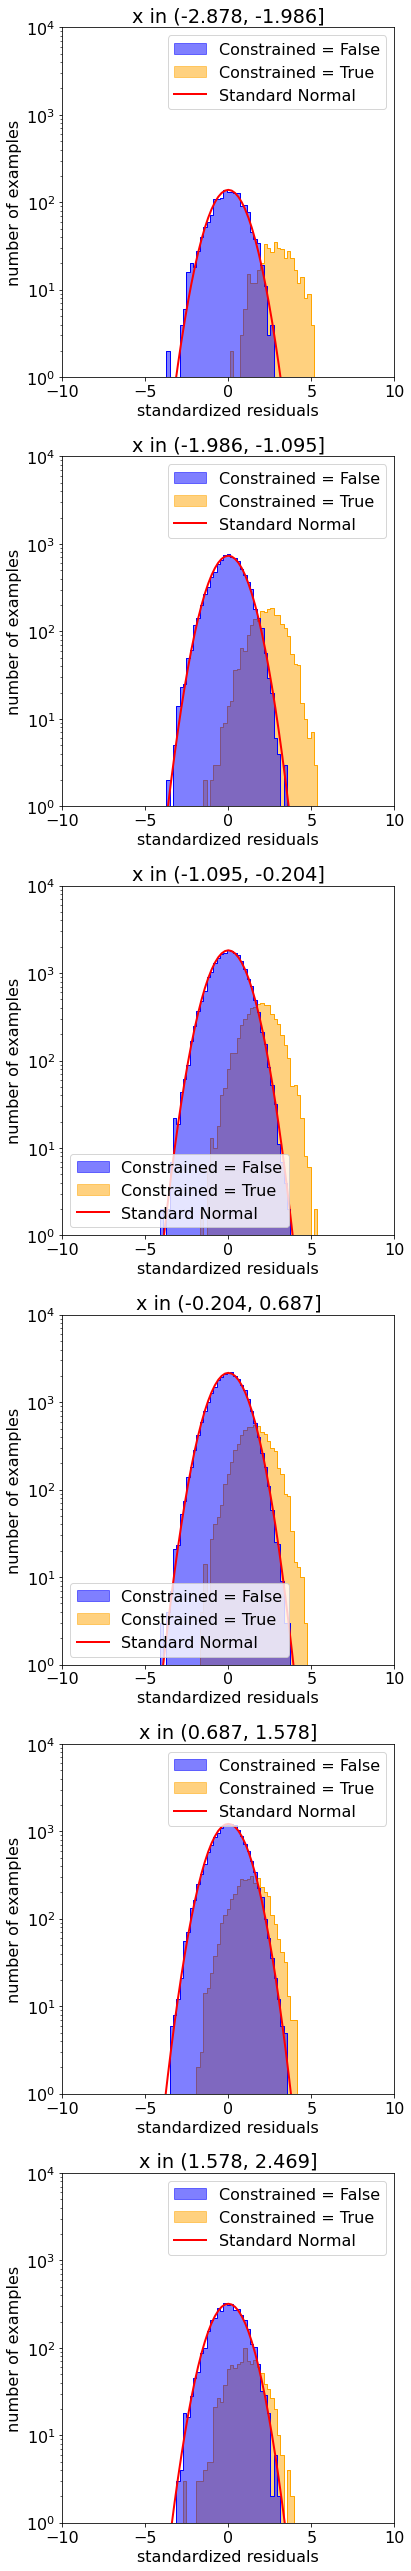

In [10]:
import seaborn as sns
from matplotlib.patches import Patch

NUMBER_EXAMPLES_MIN = 1000

def plot_residual_distributions():
    df = DATA.copy()

    df['x_bin'] = (pd
        .cut(df['x'], bins=10, labels=None)
    )
    groups = df.groupby('x_bin')
    filtered_groups = {x_bin: group for x_bin, group in groups if len(group) > NUMBER_EXAMPLES_MIN}

    fig, axes = plt.subplots(len(filtered_groups), 1, figsize=(6, 6 * len(filtered_groups)), sharey=True)
    
    for i, (x_bin, group) in enumerate(filtered_groups.items()):        
        ax = axes[i] 

        bins = np.linspace(-10, 10, 100)
        bin_centers = (bins[1:] + bins[:-1]) / 2
        bin_width = bins[1] - bins[0]

        palette = {False: 'blue', True: 'orange'}
        alpha = 0.5  

        sns.histplot(
            data=group, 
            x=f'standardized_residuals_model', 
            hue='constrained', 
            kde=False, 
            element='step', 
            bins=bins, 
            ax=ax, 
            palette=palette, 
            alpha=alpha
        )

        # plot standard normal 
        x = bin_centers
        y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
        negative_class_count = len(group[group['constrained'] == False])
        y_scaled = y * negative_class_count * bin_width  
        normal_line, = ax.plot(x, y_scaled, color='red', lw=2)

        ax.set_xlabel(f'standardized residuals')
        ax.set_ylabel('number of examples')
        ax.set_title(f'x in {x_bin}')
        ax.set_yscale('log')  
        ax.set_xlim(-10, 10)
        ax.set_ylim(1, 1e4)

        # Manually create legend handles and labels
        handles = [
            Patch(color=palette[False], alpha=alpha),
            Patch(color=palette[True], alpha=alpha),
            normal_line
        ]
        labels = [
            'Constrained = False', 
            'Constrained = True', 
            'Standard Normal'
        ]
        ax.legend(handles=handles, labels=labels)

    plt.tight_layout()
    plt.show()

plot_residual_distributions()

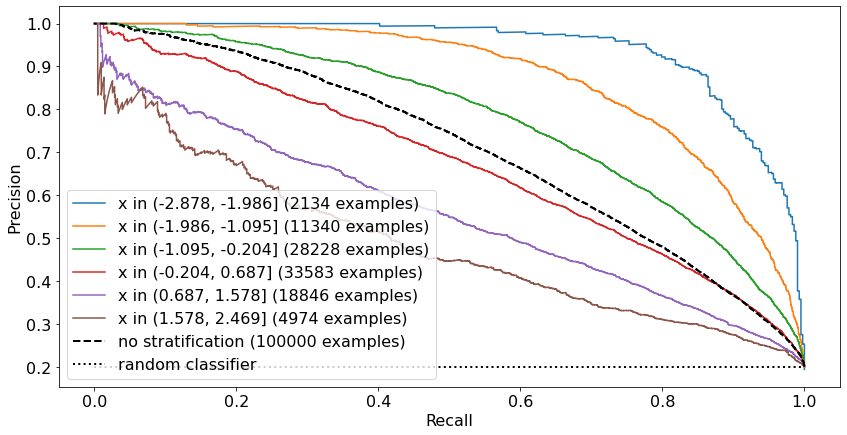

In [12]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curves():
    df = DATA.copy()

    df['x_bin'] = (pd
        .cut(df['x'], bins=10, labels=None)
    )
    groups = df.groupby('x_bin')

    pr_curves = {}
    for x_bin, group in groups:        
        precision, recall, _ = precision_recall_curve(group['constrained'], group[f'standardized_residuals_model'])
        pr_curves[x_bin] = (precision, recall, len(group))

    plt.figure(figsize=(14, 7))
    for x_bin, (precision, recall, num_examples) in pr_curves.items():
        if num_examples > NUMBER_EXAMPLES_MIN:
            plt.plot(recall, precision, label=f'x in {x_bin} ({num_examples} examples)')

    # no stratification    
    precision, recall, _ = precision_recall_curve(df['constrained'], df[f'standardized_residuals_model'])
    plt.plot(recall, precision, label=f'no stratification ({len(df)} examples)', color='black', lw=2, linestyle='--')

    plt.plot([0, 1], [POSITIVE_FRACTION, POSITIVE_FRACTION], color='black', lw=2, linestyle=':', label='random classifier')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

plot_pr_curves()